In [ ]:
!pip install stable-baselines3
!pip install gymnasium
!pip install gym-anytrading
!pip install finta

In [2]:
# OpenAI Gym
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA

# RL
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO

# Processing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data
import yfinance as yf

## Getting Data from Yahoo Finance (yFinance)

Retrieving SP500 ETF history

In [ ]:
sp500 = yf.Ticker("^GSPC")
sp500_df = sp500.history(start="2019-11-01", interval="1d", actions=False).sort_index()
sp500_df

Adding Custom Indicators

In [4]:
# Simple moving average
sp500_df['SMA'] = TA.SMA(sp500_df, 12)
# Relative strength index
sp500_df['RSI'] = TA.RSI(sp500_df)
# On-balance volume
sp500_df['OBV'] = TA.OBV(sp500_df)

sp500_df.fillna(0, inplace=True)
sp500_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2019-11-01 00:00:00-04:00,3050.719971,3066.949951,3050.719971,3066.909912,3956290000,0.000000,0.000000,0.000000e+00
2019-11-04 00:00:00-05:00,3078.959961,3085.199951,3074.870117,3078.270020,4178040000,0.000000,100.000000,4.178040e+09
2019-11-05 00:00:00-05:00,3080.800049,3083.949951,3072.149902,3074.620117,4490590000,0.000000,74.293880,-3.125500e+08
2019-11-06 00:00:00-05:00,3075.100098,3078.340088,3065.889893,3076.780029,4465510000,0.000000,77.912354,4.152960e+09
2019-11-07 00:00:00-05:00,3087.020020,3097.770020,3080.229980,3085.179932,4151990000,0.000000,86.104361,8.304950e+09
...,...,...,...,...,...,...,...,...
2023-12-04 00:00:00-05:00,4564.370117,4572.370117,4546.720215,4569.779785,4369910000,4550.991659,67.561481,1.883982e+11
2023-12-05 00:00:00-05:00,4557.250000,4578.560059,4551.680176,4567.180176,3909950000,4555.903320,66.958075,1.844883e+11
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,4558.846639,62.812044,1.802426e+11


## Making the Environment

Make a simple env

In [5]:
# frame_bound = A tuple which specifies the start and end of df
# window_size = how many prev time steps training bot have as reference data when it makes the next step
env = gym.make('stocks-v0', df = sp500_df, window_size=10, frame_bound=(50,150))

print("env information:")
print("> shape:", env.unwrapped.shape)  # (num_state, num_action)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())


env information:
> shape: (10, 2)
> df.shape: (1033, 8)
> prices.shape: (110,)
> signal_features.shape: (110, 2)
> max_possible_profit: 2.85224701693421


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Use Random Actions and Evaluate (baseline)

info: {'total_reward': 66.5400390625, 'total_profit': 0.6871213462351802, 'position': <Positions.Long: 1>}
Cumulative Returns: -31.29 %
Stability: 1.89 %
Max Drawdown:-33.51 %


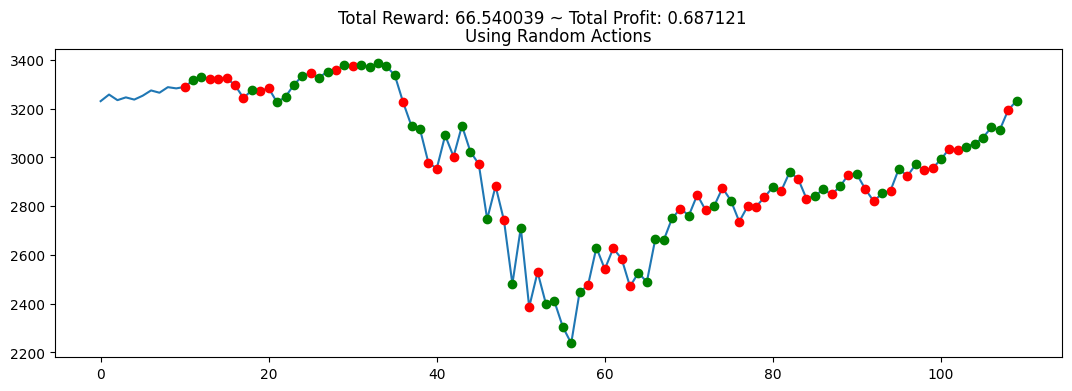

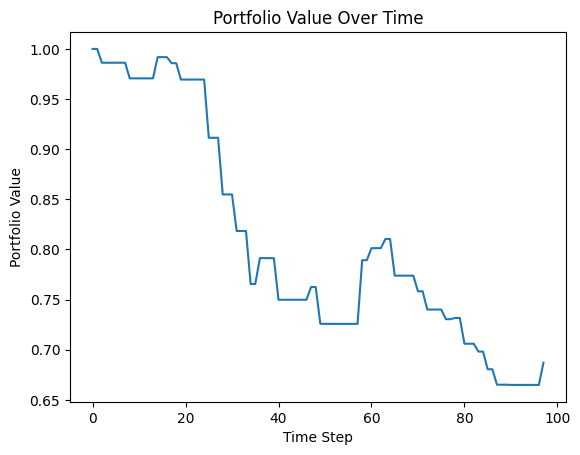

In [6]:
observation = env.reset(seed=2023)

portfolio_values = []
actions_taken = []
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        print("info:", info)
        break
    portfolio_values.append(info.get('total_profit'))  # Assuming 'total_value' is the portfolio value
    actions_taken.append(action)

daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
stability = np.std(daily_returns)

# Calculate cumulative returns
cumulative_returns = np.cumprod(1 + daily_returns) - 1

# Calculate annual return (assuming 252 trading days per year)
annual_return = (1 + cumulative_returns[-1]) ** (252 / len(portfolio_values)) - 1
# Calculate max drawdown
peak_index = np.argmax(cumulative_returns)
trough_index = np.argmin(cumulative_returns[peak_index:])
max_drawdown = cumulative_returns[trough_index + peak_index]
# Print and visualize the results
print("Cumulative Returns:", "{:.2f}".format(cumulative_returns[-1]* 100), "%")
print("Stability:","{:.2f}".format(stability * 100), "%")
print("Max Drawdown:"+"{:.2f}".format(max_drawdown * 100), "%")

plt.figure(figsize=(13,4))
plt.cla()
env.unwrapped.render_all()
plt.title("Using Random Actions")
plt.show()
plt.plot(portfolio_values)
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()

Train a model using a PPO agent using default hyperparameters (baseline)

In [ ]:
env_make = lambda: gym.make('stocks-v0', df=sp500_df, frame_bound=(50,150), window_size=5)
env = DummyVecEnv([env_make])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

Evaluation

info: {'total_reward': -20.73046875, 'total_profit': 0.7352728011741789, 'position': <Positions.Long: 1>}
Cumulative Returns: -26.24 %
Stability: 2.23 %
Max Drawdown:-30.34 %


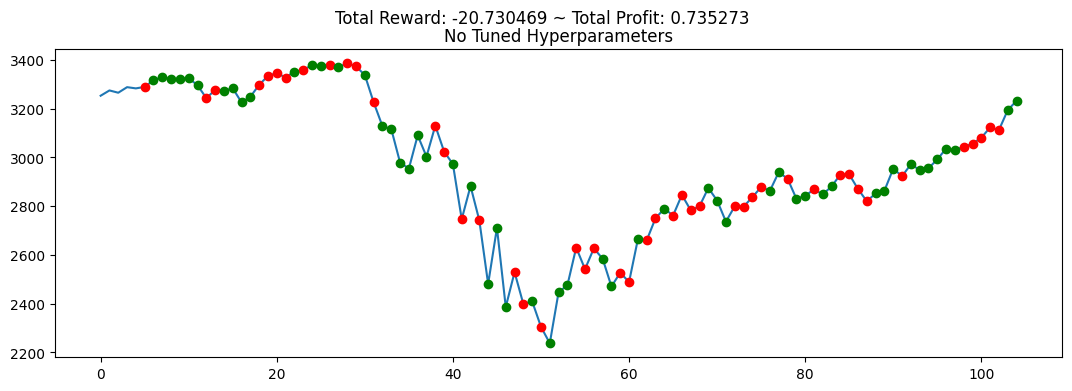

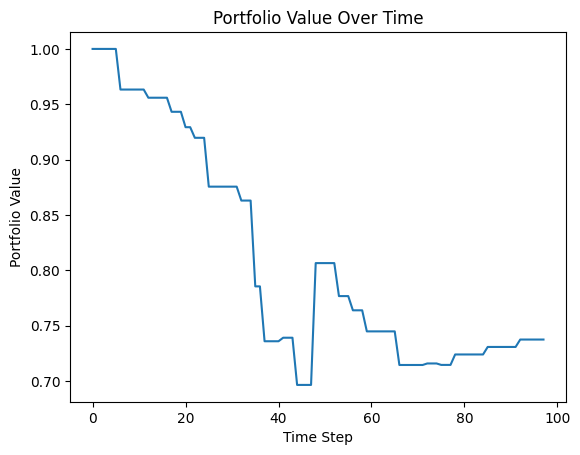

In [10]:
env = gym.make('stocks-v0', df=sp500_df, frame_bound=(50,150), window_size=5)

observation = env.reset(seed=2023)[0]

portfolio_values = []
actions_taken = []
while True:
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        print("info:", info)
        break
    portfolio_values.append(info.get('total_profit'))  # Assuming 'total_value' is the portfolio value
    actions_taken.append(action)

daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
stability = np.std(daily_returns)

# Calculate cumulative returns
cumulative_returns = np.cumprod(1 + daily_returns) - 1

# Calculate annual return (assuming 252 trading days per year)
annual_return = (1 + cumulative_returns[-1]) ** (252 / len(portfolio_values)) - 1
# Calculate max drawdown
peak_index = np.argmax(cumulative_returns)
trough_index = np.argmin(cumulative_returns[peak_index:])
max_drawdown = cumulative_returns[trough_index + peak_index]
# Print and visualize the results
print("Cumulative Returns:", "{:.2f}".format(cumulative_returns[-1]* 100), "%")
print("Stability:","{:.2f}".format(stability * 100), "%")
print("Max Drawdown:"+"{:.2f}".format(max_drawdown * 100), "%")

plt.figure(figsize=(13,4))
plt.cla()
env.unwrapped.render_all()
plt.title("No Tuned Hyperparameters")
plt.show()
plt.plot(portfolio_values)
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()
